<a href="https://colab.research.google.com/github/thayeylolu/cyberbullying/blob/main/notebooks/CountVectorizer_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [11]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
)

%matplotlib inline

## Mount Drive to connect data present in google drive

In [12]:
# from google.colab import drive
# drive.mount('/drive')

In [13]:
np.random.seed(3040)
random.seed(3040)

## Read CSV 

In [14]:
url = '/drive/MyDrive//NLP/train_data.csv'
url = "../data/processed/train_data.csv"
df = pd.read_csv(url)

### Load information about the Dataset and preview the 5 rows randomly

In [15]:
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          47692 non-null  int64 
 1   clean_txt_emoji     47349 non-null  object
 2   cyberbullying_type  47692 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


,Unnamed: 0,clean_txt_emoji,cyberbullying_type
0,0,other words your food was crapilicious katanda...,not_cyberbullying
1,1,why white aussietv MKR theblock ImACelebrityAU...,not_cyberbullying
2,2,classy whore more red velvet cupcakes,not_cyberbullying
3,3,meh thanks for the heads but not too concerned...,not_cyberbullying
4,4,this isis account pretending kurdish account l...,not_cyberbullying


### Data Cleaning

- Strip white spaces in the `clean_txt_emoji` column 
- Drop empty rows and `Unnamed: 0` column
- Select `cyberbullying_type` and `clean_txt_emoji`
- Split the data into test , validate and train dataset that and set a random state for the split
- Check the value count for each classes

In [16]:
df

,Unnamed: 0,clean_txt_emoji,cyberbullying_type
0,0,other words your food was crapilicious katanda...,not_cyberbullying
1,1,why white aussietv MKR theblock ImACelebrityAU...,not_cyberbullying
2,2,classy whore more red velvet cupcakes,not_cyberbullying
3,3,meh thanks for the heads but not too concerned...,not_cyberbullying
4,4,this isis account pretending kurdish account l...,not_cyberbullying
...,...,...,...
47687,47687,black ppl are not expected anything depended f...,ethnicity
47688,47688,turner did not withhold his disappointment tur...,ethnicity
47689,47689,swear god this dumb nigger bitch have got blea...,ethnicity
47690,47690,yea fuck you youre nigger fucking unfollow fuc...,ethnicity


In [17]:

df['clean_txt_emoji'] = df['clean_txt_emoji'].str.strip()
df = df.dropna()
df = df.drop(columns = ["Unnamed: 0"])
df = df[['cyberbullying_type', 'clean_txt_emoji']]
df['clean_txt_emoji']

train, test_valid = train_test_split(df,train_size= 0.70, random_state= 3040)
test, valid = train_test_split(test_valid,train_size= .50, random_state= 3040)
test['cyberbullying_type'].value_counts()

religion               1245
ethnicity              1241
not_cyberbullying      1208
age                    1150
gender                 1133
other_cyberbullying    1125
Name: cyberbullying_type, dtype: int64

### Encode the labels into numerical labels

In [18]:
classes = df['cyberbullying_type'].unique()

encoder = LabelEncoder()
y = encoder.fit_transform(df['cyberbullying_type'])

### Split train, test and validate data into X and y

In [19]:
X_train, y_train = train.drop(columns=["cyberbullying_type"]), train["cyberbullying_type"]
X_test, y_test = test.drop(columns=["cyberbullying_type"]), test["cyberbullying_type"]
X_val, y_valid =  valid.drop(columns=["cyberbullying_type"]),valid["cyberbullying_type"]

## Define a Count Vectorizer

- Save the train_X data as the corpus to train the vecotrizer on
- Initialize the count vectorizer
- Fit and transformer the train data on the vecotrizer
-  extract feature vectors

In [20]:

corpus_train = X_train['clean_txt_emoji']
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(corpus_train)
feat_names = vectorizer.get_feature_names_out()
feat_names.shape
X_train_vec.shape

(33144, 33381)

## Transform Valid and Test Data

- Transformer the validate and test corpus data on the vecotrizer
- extract feature vectors

In [21]:
corpus_val = X_val['clean_txt_emoji']
X_valid_vec = vectorizer.transform(corpus_val)
feat_names = vectorizer.get_feature_names_out()
print(X_valid_vec.shape)

X_test_vec = vectorizer.transform(X_test['clean_txt_emoji'])
feat_names = vectorizer.get_feature_names_out()
print(X_test_vec.shape)

(7103, 33381)
(7102, 33381)


## Model Selection 
Code adopted from Vecotr AI institute Assignment 2 notebook
- The function loops over the a series of `depth` to find the best hyperparameter to train the decision tree classfier on.

- For each depth, the validation score, train score and model is stored in a dictionary



In [22]:

## Code adopted from Vecotr AI institute Assignment 4 notebook

def select_model(depths, train_X, train_y, val_X, val_y, criteria):
    out = {}
    for dep in depths:
        # Evaluating on depth
        out[dep] = {}

        tree = DecisionTreeClassifier(criterion=criteria, max_depth=dep)
        tree = tree.fit(train_X, train_y)

        # Evaluating the model in the train and val datasets
        out[dep]['val'] = tree.score(val_X, val_y)
        out[dep]['train'] = tree.score(train_X, train_y)
        out[dep]['model'] = tree
    return out



## Finding the best model
Code adopted from Vecotr AI institute Assignment 4 notebook
- loop through different types and sizes of decision tree to find best performer based on the accuracy of the validation score
- Store the best model parameters and score in the `best_model` 


In [23]:
# loop through different types and sizes of decision tree to find best performer

best_model = {}
for criterion in ("entropy", "gini"):
    print("\nUsing criterion {}".format(criterion))
    res = select_model(range(5, 95, 5), X_train_vec, y_train, X_valid_vec, y_valid, criterion)
    best_d = None
    best_acc = 0
    for d in res:
        val_acc = res[d]['val']
        print("Depth: {}   Train: {}    Val: {}".format(d, res[d]['train'], val_acc))

        if val_acc > best_acc:
            best_d = d
            best_acc = val_acc

    test_score = res[best_d]['model'].score(X_test_vec, y_test)

    
    best_model[criterion] = [best_d , test_score]
    print("Best depth: {}    Test: {}".format(best_d, test_score))


Using criterion entropy
Depth: 5   Train: 0.5904839488293507    Val: 0.5934112346895678
Depth: 10   Train: 0.6919201062032344    Val: 0.6949176404336196
Depth: 15   Train: 0.7455648081100652    Val: 0.74475573701253
Depth: 20   Train: 0.7995112237509051    Val: 0.7905110516683092
Depth: 25   Train: 0.8294713975380159    Val: 0.815289314374208
Depth: 30   Train: 0.8387038377986966    Val: 0.8192313107137829
Depth: 35   Train: 0.8468501086169442    Val: 0.8196536674644517
Depth: 40   Train: 0.8590695148443157    Val: 0.8209207377164578
Depth: 45   Train: 0.8663106444605359    Val: 0.8237364493875827
Depth: 50   Train: 0.8749396572531981    Val: 0.8247219484724764
Depth: 55   Train: 0.8807627323195751    Val: 0.8252850908067014
Depth: 60   Train: 0.8866159787593532    Val: 0.8259890187244826
Depth: 65   Train: 0.8908701424088824    Val: 0.8258482331409264
Depth: 70   Train: 0.8950941346850109    Val: 0.8252850908067014
Depth: 75   Train: 0.8987146994931209    Val: 0.8272560889764888
Dept

## Select the model parameters with highest accuracy

In [24]:
best_model

{'entropy': [75, 0.8142776682624613], 'gini': [65, 0.8137144466347508]}

In [25]:

train_params= max([(value, key) for key, value in best_model.items()])
train_params


([75, 0.8142776682624613], 'entropy')

## Train the Decision Tree with the parameters
- Triains the model on the best hyper parameters
- Predicts the test

In [26]:
# The best performing decision tree was depth 55 with gini criterion so check its confusion matrix
best_tree = DecisionTreeClassifier(criterion=train_params[1], max_depth=train_params[0][0])
best_tree = best_tree.fit(X_train_vec, y_train)
y_test_predicted = best_tree.predict(X_test_vec)


## Generate a Confusion Matrix

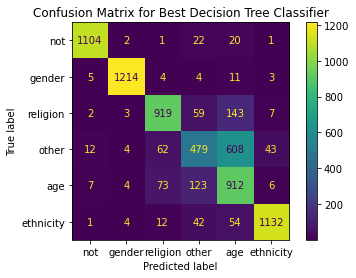

In [27]:
# Generate a more visual representation of the confusion matrix
cm = metrics.confusion_matrix(y_test, y_test_predicted, labels=best_tree.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not', 'gender', 'religion', 'other', 'age', 'ethnicity'])
disp.plot()
plt.title("Confusion Matrix for Best Decision Tree Classifier")
plt.show()

### Evaluating Models Performance 


In [28]:
test['predicition']= y_test_predicted
test

,cyberbullying_type,clean_txt_emoji,predicition
9465,gender,not sexist but woman head teacher isnt physica...,gender
31886,age,was bullied school too wrote song just like yo...,not_cyberbullying
10936,gender,doesn everyone call their female colleagues fu...,gender
2611,not_cyberbullying,would not fair kat knows nothing fair wtf hypo...,not_cyberbullying
46625,ethnicity,told you jaycen not just dumb nigger very gift...,ethnicity
...,...,...,...
42623,ethnicity,fuck obama dumb nigger bullshit electric cars ...,ethnicity
9757,gender,thicke txlege rape jokes harassment our cultur...,gender
40304,ethnicity,how can you say niggers are ugly girl make sin...,ethnicity
3853,not_cyberbullying,interesting tho that still found most them,other_cyberbullying


In [29]:
test[test.predicition != test.cyberbullying_type]

,cyberbullying_type,clean_txt_emoji,predicition
31886,age,was bullied school too wrote song just like yo...,not_cyberbullying
29672,other_cyberbullying,and the people thinks crazy and bully,not_cyberbullying
3849,not_cyberbullying,all men should follow lead please move will he...,other_cyberbullying
35279,age,way fuck bitch year old,other_cyberbullying
39079,age,watch little girl live her life after bullying...,other_cyberbullying
...,...,...,...
8266,gender,who said anything about hitting,other_cyberbullying
26849,other_cyberbullying,for the first time ever could not tell been wr...,gender
33919,age,dude fucking twitter not the fucking play scho...,not_cyberbullying
3232,not_cyberbullying,thank you roooobbb,other_cyberbullying


### Conclusion 

- The Decision Tree Predicts a total of 1342 rows incorrectly
